# Regresión softmax

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

## 1. La base de datos a utilizar

La regresión *softmax* (o tambien conocida como *regresión logística multinomial*) es el último de los algoritmos basado en modelos lineales generalizados que cubriremos en el curso de reconocimiento de patrones. Para ejemplificar su uso, vamos a utilizar una base de datos bastante comun, MNIST. 

MNIST es una base de datos de digitos escritos a mano, en formato de $20 \times 20$ pixeles. La base completa puede obtenerse en la página de Yan LeCun (http://yann.lecun.com/exdb/mnist/).

Nosotros en realidad vamos a utilizar una base de datos reducida de la original y con imágenes de calidad más reducida ($16 \times 16$ pixeles por imagen). Numpy provée un método para guardad objetos tipo numpy en un solo archivo, utilizando el método de compresión *gunzip*. Los datos ya se encuentran preprocesados y empaquetados en un archivo llamado `digitos.npz`. 

In [2]:
data = np.load("digitos.npz")

print data.keys()

['X_valida', 'X_entrena', 'T_valida', 'T_entrena']


En este caso, `data` es un objeto contenedor de numpy cuyas llaves son `X_valida`, `X_entrena`, `T_valida`, `T_entrena`. Cada una de estas son a su vez objetos tipo ndarray de numpy, los cuales contienen valores de entrada y salida, tantopara entrenamiento como para validación. No se preocupen, esto de entrenamiento y validación lo vamos a ver más adelante en la clase.

Cada renglon de x es una imagen *desenrrollada*, esto es los 256 datos de una imágen de $16 \times 16$ pixeles. Por otra parte, cada renglon de y es un vector de 10 posiciones, donde todos los valores son ceros, salvo uno, que es el que define la clase de la imagen.

Para darse una mejor idea, ejecuta el siguiente script varias veces.

-- x es de dimensiones  (9000, 256)
-- y es de dimensiones  (9000, 10)

y si escogemos la imagen  4651 veremos


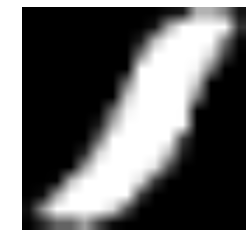

la cual es un 1


Y si miramos lo que contiene, veremos que
x[a,:] = 
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.05490196  0.09411766  0.69803923
  0.69803923  0.51764709  0.07843138  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.07450981
  0.67843139  1.          1.          1.          1.          0.19607845
  0.          0.          0.          0.          0.          0.          0.
  0.          0.11764707  0.75294125  1.          1.          1.          1.
  0.4666667   0.02352941  0.          0.          0.          0.          0.
  0.          0.          0.          0.50588238  1.          1.          1.
  1.          0.84705889  0.24705884  0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.          1.
  1.          1.          0.96470594  0.49411768  0.          0.          0.
  0.          0.  

In [3]:
x = data['X_entrena']
y = data['T_entrena']

a = np.random.randint(0, y.shape[0])

print "-- x es de dimensiones ", x.shape
print "-- y es de dimensiones ", y.shape

print "\ny si escogemos la imagen ", a, "veremos"

plt.imshow(x[a,:].reshape(16,16), cmap=plt.gray())
plt.axis('off')
plt.show()

print "la cual es un", list(y[a,:]).index(1)

print"\n\nY si miramos lo que contiene, veremos que"
print"x[a,:] = "
print x[a,:]
print "y[a,:] = "
print y[a,:]

O bien, ejecuta este script para ver un grupo grande de imágenes (puedes hacer más grande la imagen para verla mejor).

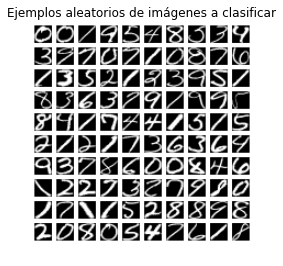

In [4]:
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
ind = indices[0:100].reshape(10,10)

imagen = np.ones((10 * 16 + 4*11, 10 * 16 + 4*11))
for i in range(10):
    for j in range(10):
        imagen[4 + i * 20: 20 + i * 20, 4 + j * 20: 20 + j * 20] = x[ind[i, j], :].reshape(16,16)
        
plt.imshow(imagen, cmap=plt.gray())
plt.axis('off')
plt.title(u"Ejemplos aleatorios de imágenes a clasificar")


Por último, vamos a hacer una función que agregue la hilera de unos para la x extendida, y simplificar más adelante su uso.

In [5]:
def extendida(x):
    """
    Agrega una columna de unos a x
    
    """
    return np.c_[np.ones((x.shape[0], 1)), x]

## 2. Regresión softmax

En la regresión *softmax* en lugar de estimar solamente un vector de parámetros, lo que tenemos que hacer es estimar una matriz de parámetros $\theta$ tal que:

$$
\theta = (\theta_1, \ldots, \theta_K) 
$$

donde $\theta_k = (\theta_{k, 0}, \ldots, \theta_{k, n})^T$ es el vector columna que parametriza la clase $k$. De esta manera, $\theta$ es ahora una matriz de dimensión $K \times n+1$. El aporte lineal a cada clase de un objeto $x^{(i)}$ está dado por

$$
z^{(i)} = \theta x^{(i)} = (z^{(i)}_1, \ldots, z^{(i)}_K)^T
$$

el cual es de dimensión $K \times 1$ (un valor por cada clase). La probabilidad de pertenecer a la clase $c$ está dada por:

$$
\hat{y}_c^{(i)} = softmax_k(z^{(i)}) = \frac{\exp(z_c^{(i)})}{\sum_{r=1}^K \exp(z_r^{(i)})}.
$$

Como se puede ver, $\hat{y}^{(i)}$ en realizad es el vector de las exponenciales de $z^{(i)}$ normalizadas. 

#### Ejercicio 1. Con esta información, realiza la función *softmax*, de manera que si recibe un ndarray de dimensiones $ T \times K$ con $T$ vectores, regrese la matriz de mismas dimensiones con el cálculo *softmax* para cada matriz (20 puntos).

In [24]:
def softmax(z):
    """
    Calculo de la regresión softmax
    
    @param z: ndarray de dimensión (T, K) donde z[i, :] es el vector de aportes lineales de el objeto i
    
    @return: un ndarray de dimensión (T, K) donde cada columna es el calculo softmax de su respectivo vector de entrada.
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    
    a = np.exp(z)
    
    return a / a.sum(axis=1).reshape(-1,1)
    
    '''
    R = z.shape[0]
    C = z.shape[1]
    
    fuckyou = np.zeros_like(z)
    for i in xrange(R):
        for j in xrange(C):
            fuckyou[i][j] = np.exp(z[i][j])/np.sum(np.exp(z[i]))
            
    return fuckyou
    '''
    #--------------------------------------------------------------------------------

def test_softmax():
    z = np.array([[1, 0.1, -10], [20, 100, 2.5], [2, 2.1, 2.2]])
    y_hat = softmax(z)
    y_selec = y_hat.argmax(axis=1)
    y_hat_acc = y_hat.sum(axis=1) 


    assert abs(y_hat_acc[0] - 1) < 1e-10
    assert abs(y_hat_acc[1] - 1) < 1e-10
    assert abs(y_hat_acc[2] - 1) < 1e-10

    assert y_selec[0] == 0
    assert y_selec[2] == 2
    
    return "Paso la prueba"

print test_softmax()


Paso la prueba


Y ahora es necesario implementar la función de costo, la cual es:

$$
J(\theta) = -\frac{1}{T}\sum_{i=1}^T \sum_{c=1}^K y_c^{(i)} \log(\hat{y}_c^{(i)}),
$$

donde $y_c^{(i)}$ es un valor de 0 o 1 dependiendo si el objeto $i$ pertenece a la clase $c$ o no, mientras que $\hat{y}_c^{(i)}$ es la probabilidad que el objeto $i$ pertenezca a la clase $c$ conociendo $x^{(i)}$ y parametrizado por $\theta$. Este criterio se derivó de una distribución de la familia exponencial en clase y no se detalla en la libreta.

#### Ejercicio 2. Implementa la función de costo de manera relativamente eficiente, utilizando las facilidades que presenta numpy (10 puntos)

In [13]:
def costo(theta, x, y):
    """
    Calcula el costo para la regresión softmax parametrizada por theta, 
    con el conjunto de datos dado por (x, y)
    
    @param theta: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos
    @param y: ndarray de dimensión (T, K) con la clase por cada dato
    
    @return: Un valor flotante
    
    """
    yhat = softmax(x.dot(theta))
    return -(1.0/y.shape[0]) * np.sum(y * np.log(yhat))
    
    '''
    costo = 0
    T = 0
    K = 0
    for i in xrange(x.shape[0]):
        K = 0
        for k in xrange(y.shape[1]):
            K += y[i][k]*np.log(softmax(x.dot(theta)))[i][k]
        T += K
        
    
    #return -np.sum(y*np.log(softmax(x.dot(theta))))/T
    return -T/x.shape[0]
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------




    '''
    #--------------------------------------------------------------------------------

def test_costo():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    theta = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    assert costo(theta, x, y) < 0.1
    return "Paso la prueba"
    
print test_costo()

[[  9.35507482e-01   1.71344172e-02   4.70442733e-02   3.13827798e-04]
 [  4.20098461e-02   8.43790316e-01   5.23653124e-06   1.14194601e-01]
 [  1.68824720e-02   6.21071436e-03   9.31015497e-01   4.58913168e-02]
 [  4.45810978e-05   1.79852985e-02   6.09403213e-06   9.81964026e-01]]
Paso la prueba


#### Ejercicio 3. Implementa la función para predecir el valor de y estimada sin tener que calcular la función softmax (10 puntos)

In [20]:
def predice(theta, x):
    """
    Prediccion de y_hat a partir de la matriz theta para los valores de x
    
    @param theta: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos

    @return: ndarray de dimensión (T, K) con la clase por cada dato (unos y ceros)
    
    """
    z = x.dot(theta)
    indices = np.argmax(z, axis = 1)
    a = np.zeros_like(z)
    a[range(a.shape[0]), indices] = 1
    
    #for i in xrange(a.shape[0]):
    #    a[i][indices[i]] = 1
    return a
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    
    
    #--------------------------------------------------------------------------------

def prueba_prediccion():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    theta = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    assert abs((y - predice(theta, x)).sum()) < 1e-12 
    return "Paso la prueba"
    
print prueba_prediccion()

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Paso la prueba


Y por último tenemos que implementar el gradiente para poder utilizar los métodos de optimización (ya sea por descenso de gradiente o por algún método de optimización.

El gradiente se obtiene a partir de las derivadas parciales:

$$
\frac{\partial J(\theta)}{\partial \theta_{s, r}} = - \frac{1}{T} \sum_{i = 1}^T \left(y_k^{(i)} -  \sum_{j=1}^K \hat{y}_j^{i}\right) x_s^{(i)},
$$

donde $k$ es la clase a la que pertenece el ejemplo $i$. Esto implica que cuando $k = r$, entonces solamente tenemos $1 - \hat{y}_k^{(i)}$ para este dato. Si $k \neq r$ entonces tendremos $-\hat{y}_r^{(i)}$. 

Esto se puede resolver en forma matricial como

$$
\nabla J(\theta) = - \frac{1}{T} X^T (Y - \hat{Y})
$$


#### Ejercicio 4. Implementa el gradiente de la manera que menos se dificulte (15 puntos)

In [15]:
def gradiente(theta, x, y):
    """
    Calculo del gradiente para el problema de regresión softmax
    
    @param theta: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos
    @param y: ndarray de dimensión (T, K) con la clase por cada dato
    
    @return: Un ndarray de mismas dimensiones que theta
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------

    return -1.*(x.T.dot(y - softmax(x.dot(theta))))/x.shape[0]



    #--------------------------------------------------------------------------------

def prueba_gradiente():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    theta = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    g = gradiente(theta, x, y)
    assert np.abs(g).max() < 0.05
    
    return "Paso la prueba"
    
print prueba_gradiente()    
    
    

[[  9.35507482e-01   1.71344172e-02   4.70442733e-02   3.13827798e-04]
 [  4.20098461e-02   8.43790316e-01   5.23653124e-06   1.14194601e-01]
 [  1.68824720e-02   6.21071436e-03   9.31015497e-01   4.58913168e-02]
 [  4.45810978e-05   1.79852985e-02   6.09403213e-06   9.81964026e-01]]
Paso la prueba


Ahora si, ya nos encontramos en capacidad para realizar el aprendizaje para la regresión softmax.

#### Ejercicio 5. Implementa la regresión softmax utilizando el método de descenso de gradiente (15 puntos)

In [16]:
def dg_softmax_lotes(theta, x, y, alpha=None, max_epoch=10000, epsilon=1e-3, errores=False):
    """
    Descenso de gradiente por lotes para la clasificación softmax
    
    """
    historial = np.zeros((max_epoch)) if errores else None
    for epoch in xrange(max_epoch):
        #--------------------------------------------------------------------------------
        # AGREGA AQUI TU CÓDIGO
        #--------------------------------------------------------------------------------
        inc = gradiente(theta, x, y)
        if np.abs(inc.max()) <= epsilon:
            return theta, historial
        theta -= alpha*inc
        if errores:
            historial[epoch] = costo(theta, x, y)

        #--------------------------------------------------------------------------------
    return theta, historial
        
    

Pero para utilizar el descenso de gradiente hay que ajustar un valor de $\alpha$.

[[ 0.09998209  0.07762913  0.08583507 ...,  0.0937731   0.11783465
   0.09721395]
 [ 0.09454434  0.08605378  0.08950766 ...,  0.11270964  0.09694972
   0.12306051]
 [ 0.08560267  0.07169643  0.08455104 ...,  0.09734353  0.12827092
   0.13315714]
 ..., 
 [ 0.07859053  0.08639056  0.1023714  ...,  0.10307705  0.08916269
   0.13713622]
 [ 0.08447356  0.09287647  0.12686358 ...,  0.08617105  0.10176122
   0.10976579]
 [ 0.07029525  0.09079905  0.12084971 ...,  0.08665504  0.09362374
   0.14318016]]
[[ 0.45052369  0.06089571  0.04990893 ...,  0.02565767  0.0910368
   0.02290426]
 [ 0.12334502  0.13759401  0.08415795 ...,  0.06754362  0.16691562
   0.0837523 ]
 [ 0.26652789  0.04860263  0.08357321 ...,  0.07334924  0.16358093
   0.06291287]
 ..., 
 [ 0.0705528   0.18765163  0.07524683 ...,  0.14624736  0.11220156
   0.12854607]
 [ 0.23535466  0.10672297  0.08444297 ...,  0.04790427  0.19375376
   0.07251382]
 [ 0.10593127  0.10286058  0.08949924 ...,  0.10109382  0.1255872
   0.16342999]]
[[

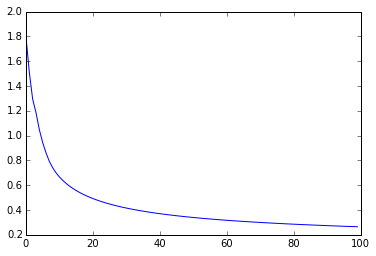

In [17]:
# Ajusta un valor de alpha razonable

alfita = 1

T, K = y.shape
n = x.shape[1]

theta = 0.1 * (np.random.random((n + 1, K)) - 0.5)
theta, e_hist = dg_softmax_lotes(theta, extendida(x), y, alpha=alfita, max_epoch=100, errores=True)
plt.plot(e_hist)



y para probarlo vamos a aprender a clasificar a los digitos de nuestra base de datos


In [29]:
theta = 0.1 * (np.random.random((n + 1, K)) - 0.5)
theta, e_hist = dg_softmax_lotes(theta, extendida(x), y, alpha=alfita, max_epoch=1000)

print "El costo de la solución final es de ", costo(theta, extendida(x), y)

y_estimada = predice(theta, extendida(x))

errores = np.where(y.argmax(axis=1) == y_estimada.argmax(axis=1), 0, 1)

print "\nLos datos utilizados para el aprendizaje mal clasificados son el ", 100 * errores.mean(),"%"

# Esto solo es para hacerla más emocionante
x_test = data['X_valida']
y_test = data['T_valida']
y_estimada_T = predice(theta, extendida(x_test))
errores = np.where(y_test.argmax(axis=1) == y_estimada_T.argmax(axis=1), 0, 1)

print "\nY con los datos de pureba el error es del ", 100 * errores.mean(),"%"


El costo de la solución final es de  0.18505383444

Los datos utilizados para el aprendizaje mal clasificados son el  4.51111111111 %

Y con los datos de pureba el error es del  6.2 %


¿Será esta la mejor solución? ¿Será una buena solución? 

## 2. Regresión logística "Uno contra todos"

Otra manera de resolver este problema es el utilizar la noción de "Uno contra todos", esto es, que cada una de las clases sea considerada en si como una única regresión logística. De esta manera, se intenta resolver en forma independiente $K$ regresiones logísticas, y por lo tanto se obtienen $K$ vectores $\theta_c$, uno por cada clase.

Claro que realizar $K$ regresiones logísticas en forma secuencial no es la forma más eficiente de resolver el problema, ya que se pueden ir realizando todas de forma simultanea. Para este caso vamos a definor una matriz $\theta$ similar a la matriz $\theta$ utilizada en softmax, así como el vector $z^{(i)}$ como el vector de las $K$ combinaciones lineales de las características con los parámetros de cada clase. 

Lo que cambia fundamentalmente es la forma en que se calcula $\hat{y}^{(i)}_c$ el cual es ahora la probabilidad de que un objeto pertenezca a la clase $c$ en relación a no pertenecer,

$$y^{(i)}_c = g(z_c^{(i)}) = \frac{1}{1 + \exp(-z_c^{(i)})}$$

Y en este caso, el costo se calcularía por clase. Debido a que los parámeros para cada clase no interactuan entre si, la minimozación de cada uno de los costos, implica la minimozación de la sua de los costos, por lo que se podría establecer un costo único de la forma

$$ 
J(\theta) = J(\theta_1, \ldots, \theta_K) = \frac{1}{T}\sum_{c=1}^K 
\sum_{i=1}^T -y^{(i)}_c \log(\hat{y}^{(i)}_c) - (1 - y^{(i)}_c) \log((1 - \hat{y}^{(i)}_c))
$$

despues de algunos acomodos utilizando algebra lineal, podemos expresar el gradiente como


$$
\nabla J(\theta) = - \frac{1}{T} X^T (Y - \hat{Y})
$$

que si bien parece identico al utilizado por el algoritmo de regresión softmax, la forma en que $\hat{Y}$ se calcula es fundamentalmente diferente. Es de notar que la función logística es más sencilla y numéricamente más estable que la fución softmax.


#### Ejercicio 6. Desarrolla todas las funciones para realizar la regresión logística en  forma "one vs all", utilizalo para clasificar la base de datos y compara los resultados con los obtenidos utilizando regresión softmax (30 puntos). 

In [13]:
"""
En esta tarea no se anexa ninguna función, ni base de pruebas, 
ya que se requiere relativamente pocos cambios a las funciones 
ya desarrolladas con anterioridad.
"""
#--------------------------------------------------------------------------------
# AGREGA AQUI TU CÓDIGO
#--------------------------------------------------------------------------------
def logistica_1vsALL(z):
    
    return 1.0/(1 + np.exp(-z))

def costo_1vsALL(theta, x, y):
    yhat = logistica_1vsALL(x.dot(theta))
    return (1.0/x.shape[0])*(np.sum(-y*np.log(yhat) - (1-y)*np.log(1-yhat)) )
    

def gradiente_1vsALL(theta, x, y):
    return -1.0*(x.T.dot(y - logistica_1vsALL(x.dot(theta))))/x.shape[0]


In [8]:
def dg_softmax_lotes1vsALL(theta, x, y, alpha=None, max_epoch=10000, epsilon=1e-3, errores=False):
    """
    Descenso de gradiente por lotes para la clasificación softmax
    
    """
    historial = np.zeros((max_epoch)) if errores else None
    for epoch in xrange(max_epoch):
        #--------------------------------------------------------------------------------
        # AGREGA AQUI TU CÓDIGO
        #--------------------------------------------------------------------------------
        inc = gradiente_1vsALL(theta, x, y)
        if np.abs(inc.max()) <= epsilon:
            return theta, historial
        theta -= alpha*inc
        if errores:
            historial[epoch] = costo_1vsALL(theta, x, y)

        #--------------------------------------------------------------------------------
    return theta, historial

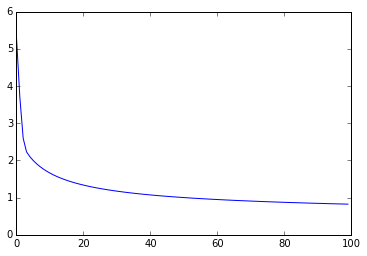

In [28]:
# Ajusta un valor de alpha razonable

alfita = .7

T, K = y.shape
n = x.shape[1]

theta = 0.1 * (np.random.random((n + 1, K)) - 0.5)
theta, e_hist = dg_softmax_lotes1vsALL(theta, extendida(x), y, alpha=alfita, max_epoch=100, errores=True)
plt.plot(e_hist)

In [30]:


print "El costo de la solución final es de ", costo_1vsALL(theta, extendida(x), y)

y_estimada = predice(theta, extendida(x))

errores = np.where(y.argmax(axis=1) == y_estimada.argmax(axis=1), 0, 1)

print "\nLos datos utilizados para el aprendizaje mal clasificados son el ", 100 * errores.mean(),"%"

# Esto solo es para hacerla más emocionante
x_test = data['X_valida']
y_test = data['T_valida']
y_estimada_T = predice(theta, extendida(x_test))
errores = np.where(y_test.argmax(axis=1) == y_estimada_T.argmax(axis=1), 0, 1)

print "\nY con los datos de pureba el error es del ", 100 * errores.mean(),"%"

El costo de la solución final es de  0.509454272978
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]

Los datos utilizados para el aprendizaje mal clasificados son el  5.2 %
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]

Y con los datos de pureba el error es del  6.8 %
